<h2>Получение данных</h2>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Создаем синтетический датасет
np.random.seed(42)
n_samples = 200

data = {
    # Факторы
    'f0': np.random.normal(220, 50, n_samples),  # основная частота (Гц)
    'f1': np.random.normal(500, 100, n_samples),  # первая форманта (Гц)
    'f2': np.random.normal(1500, 200, n_samples), # вторая форманта (Гц)
    'intensity': np.random.normal(70, 10, n_samples), # интенсивность (дБ)
    'speaking_rate': np.random.normal(4.5, 1, n_samples), # темп речи (слоги/сек)
    'position_in_word': np.random.randint(1, 6, n_samples), # позиция в слове (номер слога)
    'stress': np.random.randint(0, 3, n_samples), # ударность (0-безударный, 1-ударный)
}

# Создаем целевой параметр - длительность гласного (мс) с какой-то зависимостью от фонетических параметров
duration = (
    150 +  # базовая длительность
    -0.2 * (data['f0'] - 220) +  # чем выше F0, тем короче гласный
    0.1 * (data['f1'] - 500) +   # чем выше F1, тем длиннее
    -0.05 * (data['f2'] - 1500) + # чем выше F2, тем короче
    0.8 * data['intensity'] +    # чем громче, тем длиннее
    -15 * data['speaking_rate'] + # чем быстрее речь, тем короче
    5 * data['position_in_word'] + # чем дальше в слове, тем длиннее
    40 * data['stress'] +        # ударные длиннее
    np.random.normal(0, 10, n_samples)  # случайный шум
)

data['vowel_duration'] = duration

# Создаем DataFrame
df = pd.DataFrame(data)

print("Датасет:")
print(df.head())
print(f"\nРазмер датасета: {df.shape}")

Датасет:
           f0          f1           f2  intensity  speaking_rate  \
0  244.835708  535.778736  1181.114468  77.569886       5.438284   
1  213.086785  556.078453  1380.124995  60.778347       3.983955   
2  252.384427  608.305124  1501.048740  78.696059       4.596121   
3  296.151493  605.380205  1509.396119  83.556379       4.037725   
4  208.292331  362.233063  1409.986906  74.134349       4.065504   

   position_in_word  stress  vowel_duration  
0                 4       2      240.688403  
1                 1       0      149.938783  
2                 3       1      220.039018  
3                 5       0      185.346470  
4                 3       0      137.708413  

Размер датасета: (200, 8)


<h2>Исследовательский анализ данных</h2>

Статистика параметров:
               f0          f1           f2   intensity  speaking_rate  \
count  200.000000  200.000000   200.000000  200.000000     200.000000   
mean   217.961452  508.586819  1482.868993   70.089666       4.628251   
std     46.550196   98.700381   198.808395   10.195743       0.955933   
min     89.012745  175.873266  1005.671100   43.031134       2.076121   
25%    184.743616  439.416246  1341.224312   62.935308       3.969099   
50%    219.790406  507.883935  1484.480016   70.222625       4.630537   
75%    245.042624  568.723114  1614.417648   76.851771       5.218316   
max    356.008458  885.273149  2115.776162   96.323821       7.026932   

       position_in_word      stress  vowel_duration  
count        200.000000  200.000000      200.000000  
mean           3.065000    0.940000      190.198199  
std            1.400206    0.818382       41.761060  
min            1.000000    0.000000      101.817318  
25%            2.000000    0.000000      160.3032

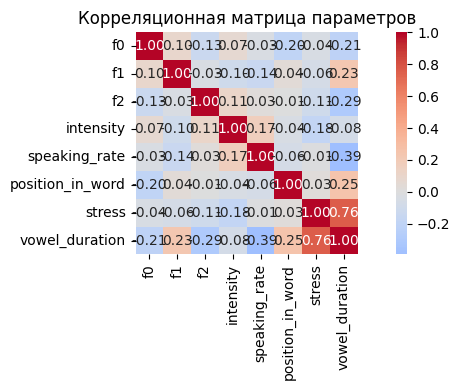

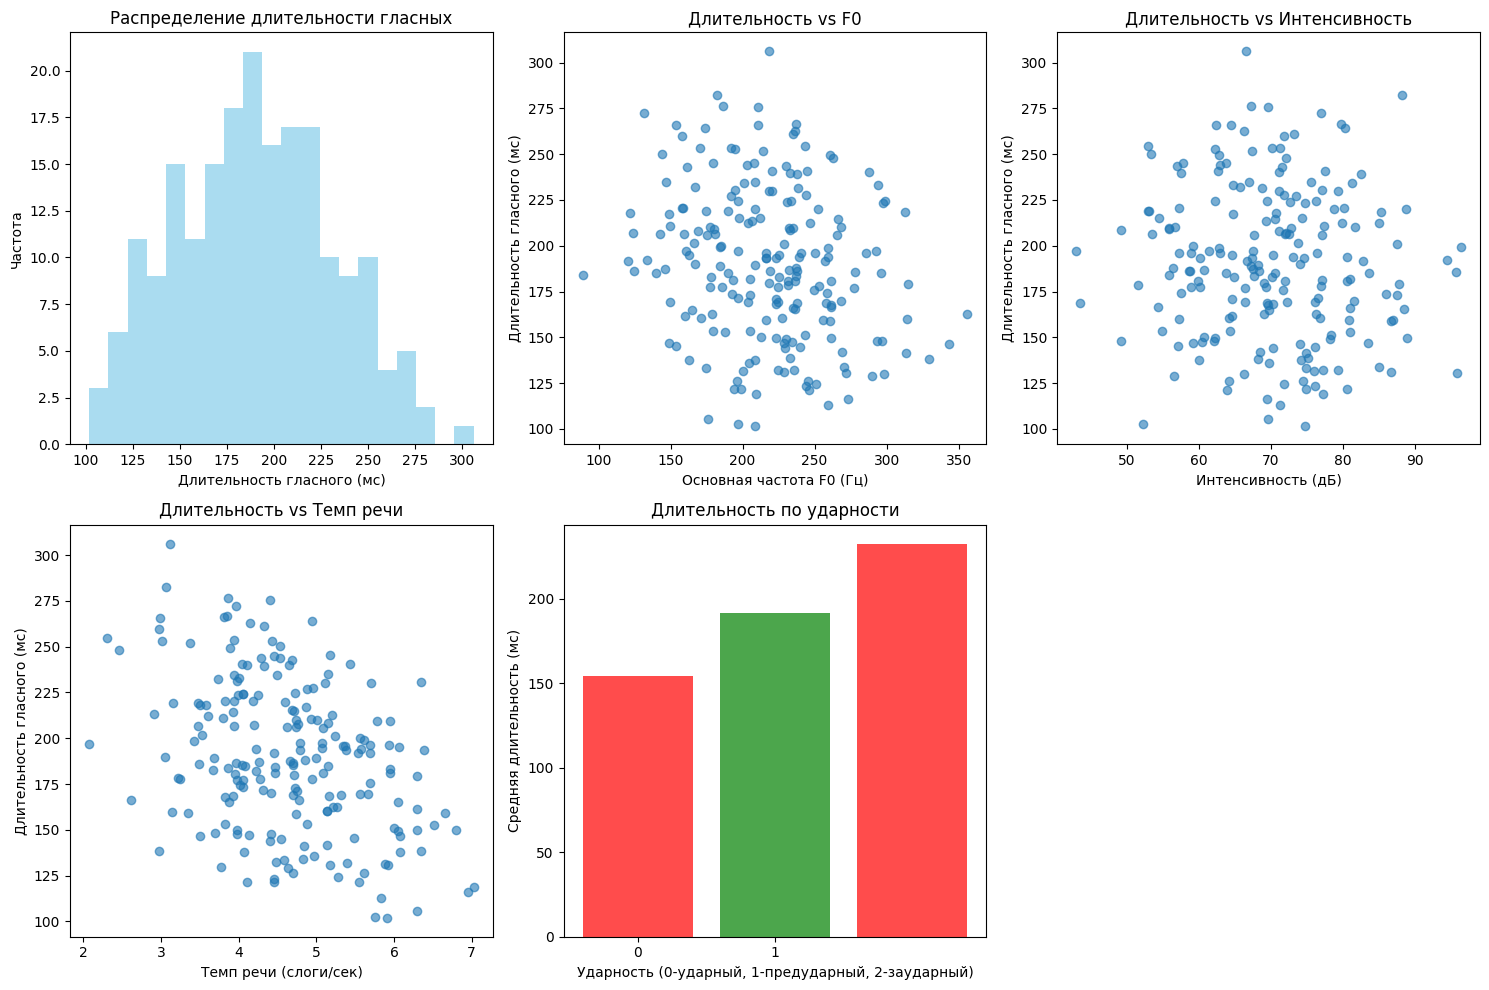

In [29]:
# Основная статистика
print("Статистика параметров:")
print(df.describe())

# Корреляционная матрица
plt.figure(figsize=(8, 4))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Корреляционная матрица параметров')
plt.tight_layout()
plt.show()

# Визуализация распределения длительности гласных
plt.figure(figsize=(15, 10))

# Распределение длительности
plt.subplot(2, 3, 1)
plt.hist(df['vowel_duration'], bins=20, alpha=0.7, color='skyblue')
plt.xlabel('Длительность гласного (мс)')
plt.ylabel('Частота')
plt.title('Распределение длительности гласных')

# Длительность vs F0
plt.subplot(2, 3, 2)
plt.scatter(df['f0'], df['vowel_duration'], alpha=0.6)
plt.xlabel('Основная частота F0 (Гц)')
plt.ylabel('Длительность гласного (мс)')
plt.title('Длительность vs F0')

# Длительность vs интенсивность
plt.subplot(2, 3, 3)
plt.scatter(df['intensity'], df['vowel_duration'], alpha=0.6)
plt.xlabel('Интенсивность (дБ)')
plt.ylabel('Длительность гласного (мс)')
plt.title('Длительность vs Интенсивность')

# Длительность vs темп речи
plt.subplot(2, 3, 4)
plt.scatter(df['speaking_rate'], df['vowel_duration'], alpha=0.6)
plt.xlabel('Темп речи (слоги/сек)')
plt.ylabel('Длительность гласного (мс)')
plt.title('Длительность vs Темп речи')

# Длительность по ударности
plt.subplot(2, 3, 5)
df_grouped = df.groupby('stress')['vowel_duration'].mean()
colors = ['red', 'green']
plt.bar(df_grouped.index, df_grouped.values, color=colors, alpha=0.7)
plt.xlabel('Ударность (0-ударный, 1-предударный, 2-заударный)')
plt.ylabel('Средняя длительность (мс)')
plt.title('Длительность по ударности')
plt.xticks([0, 1])


plt.tight_layout()
plt.show()

<h2>Подготовка факторов</h2>

In [30]:
# Разделяем на признаки и целевую переменную
X = df.drop('vowel_duration', axis=1)
y = df['vowel_duration']

print("Признаки для модели:")
print(X.columns.tolist())
print(f"\nЦелевая переменная: vowel_duration")

# Разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nРазмеры выборок:")
print(f"Тренировочная: {X_train.shape}")
print(f"Тестовая: {X_test.shape}")

# Масштабируем числовые признаки (кроме бинарных и категориальных)
scaler = StandardScaler()
numerical_features = ['f0', 'f1', 'f2', 'intensity', 'speaking_rate']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("\nМасштабированные данные (первые 5 строк):")
print(X_train_scaled.head())

Признаки для модели:
['f0', 'f1', 'f2', 'intensity', 'speaking_rate', 'position_in_word', 'stress']

Целевая переменная: vowel_duration

Размеры выборок:
Тренировочная: (160, 7)
Тестовая: (40, 7)

Масштабированные данные (первые 5 строк):
           f0        f1        f2  intensity  speaking_rate  position_in_word  \
79  -2.047941 -0.483657  1.271147   1.194250       1.097003                 3   
197  0.230701  1.340621 -0.840784   0.627791       0.515330                 1   
38  -1.346263 -0.773656 -1.570096  -1.264838       0.880215                 3   
24  -0.512185 -0.574513  0.793876   1.503021      -0.638714                 3   
122  1.559889 -0.937744 -0.522596  -1.320734      -0.024193                 2   

     stress  
79        1  
197       0  
38        0  
24        0  
122       0  


<h2>Обучение модели линейной регрессии</h2>

In [31]:
# Создаем и обучаем модель
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

print("Модель линейной регрессии обучена!")
print(f"Коэффициенты: {lr_model.coef_}")
print(f"Intercept: {lr_model.intercept_:.2f}")

# Создаем DataFrame с важностью признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_,
    'abs_coefficient': np.abs(lr_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nВажность признаков:")
print(feature_importance)

Модель линейной регрессии обучена!
Коэффициенты: [ -9.38376584  10.17772347  -9.93656153   8.90872973 -15.66011529
   4.67004338  39.48758993]
Intercept: 139.15

Важность признаков:
            feature  coefficient  abs_coefficient
6            stress    39.487590        39.487590
4     speaking_rate   -15.660115        15.660115
1                f1    10.177723        10.177723
2                f2    -9.936562         9.936562
0                f0    -9.383766         9.383766
3         intensity     8.908730         8.908730
5  position_in_word     4.670043         4.670043


<h2>Оценка качества модели на тестовой выборке и предсказания</h2>

=== РЕЗУЛЬТАТЫ МОДЕЛИ ===
Среднеквадратичная ошибка (MSE): 117.97
Корень из MSE (RMSE): 10.86 мс
R² коэффициент: 0.901


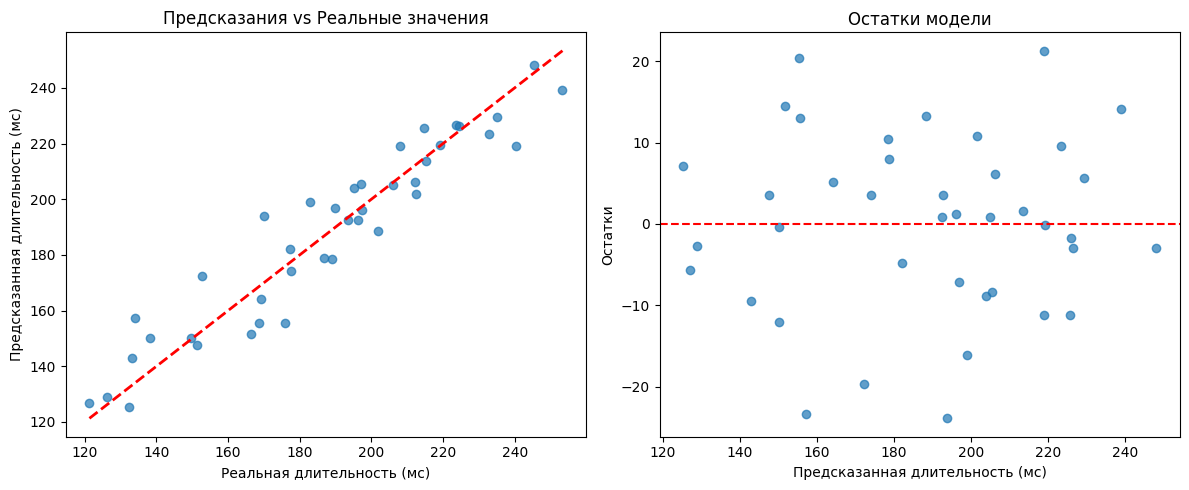


Анализ ошибок:
Среднее ошибок: 0.06
Стандартное отклонение ошибок: 11.00


In [32]:
# Предсказания на тестовой выборке
y_pred = lr_model.predict(X_test_scaled)

# Метрики качества
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("=== РЕЗУЛЬТАТЫ МОДЕЛИ ===")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Корень из MSE (RMSE): {rmse:.2f} мс")
print(f"R² коэффициент: {r2:.3f}")

# Визуализация предсказаний vs реальные значения
plt.figure(figsize=(12, 5))

# График предсказаний vs реальных значений
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальная длительность (мс)')
plt.ylabel('Предсказанная длительность (мс)')
plt.title('Предсказания vs Реальные значения')

# Ошибка
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанная длительность (мс)')
plt.ylabel('Остатки')
plt.title('Остатки модели')

plt.tight_layout()
plt.show()

# анализ ошибок
print(f"\nАнализ ошибок:")
print(f"Среднее ошибок: {residuals.mean():.2f}")
print(f"Стандартное отклонение ошибок: {residuals.std():.2f}")

<h2>Практическое применение обученной модели</h2>

In [33]:
# Функция для предсказания длительности нового гласного
def predict_vowel_duration(f0, f1, f2, intensity, speaking_rate, 
                          position_in_word, stress):
    """
    Предсказание длительности гласного на основе его параметров
    """
    # Создаем DataFrame с входными данными
    new_data = pd.DataFrame({
        'f0': [f0],
        'f1': [f1],
        'f2': [f2],
        'intensity': [intensity],
        'speaking_rate': [speaking_rate],
        'position_in_word': [position_in_word],
        'stress': [stress],
    })
    
    # Масштабируем числовые признаки
    new_data_scaled = new_data.copy()
    new_data_scaled[numerical_features] = scaler.transform(new_data[numerical_features])
    
    # Предсказываем длительность
    predicted_duration = lr_model.predict(new_data_scaled)[0]
    
    return predicted_duration

# Примеры предсказаний
print("=== ПРИМЕРЫ ПРЕДСКАЗАНИЙ ===")

dur1 = predict_vowel_duration(
    f0=200, f1=600, f2=1200, intensity=75,
    speaking_rate=3.0, position_in_word=2, stress=1
)
print(f"Пример 1: {dur1:.1f} мс")

dur2 = predict_vowel_duration(
    f0=250, f1=400, f2=1800, intensity=65,
    speaking_rate=6.0, position_in_word=4, stress=0
)
print(f"Пример 2: {dur2:.1f} мс")

dur3 = predict_vowel_duration(
    f0=180, f1=800, f2=1000, intensity=80,
    speaking_rate=4.0, position_in_word=1, stress=1
)
print(f"Пример 3: {dur3:.1f} мс")

=== ПРИМЕРЫ ПРЕДСКАЗАНИЙ ===
Пример 1: 246.4 мс
Пример 2: 96.4 мс
Пример 3: 264.7 мс


Задание: обучите модель на реальных данных. Данные об интенсивности, ЧОТ и формантных частотах возьмите из середины звука (parselmouth). Количество слогов в секунду возьмите в среднем по одному звуковому файлу.

Данные: https://disk.yandex.ru/d/hinGhuakbv2R7w